In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

#RANDOM_SEED = 1

time_slot = 20

#resource requirement for each task r^k_m
r = np.array([[1, 2],
        [3, 4]])

Beta = np.array([0.5, 0.5]) #geometric distribution parameter

Lambda = np.array([0.3,0.3]) #iid Bernoulli process parameter







RANDOM_SEED = 42



timeslot_duration = 100
num_timeslot = 10000


K = 3;
M = 3; 
#action = np.array(np.zeros(M)) #action matrix for RL, 0 is don't process, 1 is process
r = np.random.randint(1,3,(M,K))

C_k = np.random.randint(5,15,K)

Beta = np.full(M,0.1)

U = np.random.randint(1,10,M)#reward per task

print(r," resource required per task per type")
print(U," reward per task")
print(Beta," geometric processing time parameter")
print(C_k," global resources of type K")



[[2 2 2]
 [2 1 2]
 [1 1 2]]  resource required per task per type
[8 8 1]  reward per task
[0.1 0.1 0.1]  geometric processing time parameter
[14 13  5]  global resources of type K


In [ ]:
!pip install simpy
import simpy

In [ ]:

class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,input1,input2,n_actions):
    self.memsize = max_size
    self.mem_cntr = 0 
    self.state_memory = np.zeros((self.memsize,input1,input2))
    self.new_state_memory = np.zeros((self.memsize,input1,input2))
    self.action_memory = np.zeros((self.memsize), dtype= np.int8)
    self.reward_memory = np.zeros(self.memsize)


  def store_transistion(self,state,action,reward,newstate):
    index = self.mem_cntr % self.memsize
    self.state_memory[index] = state
    self.new_state_memory[index] = newstate
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr, self.memsize)
    batch = np.random.choice(max_mem,batch_size)

    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    return states,actions,rewards,new_states




In [ ]:
class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size, input_dims, input1,input2,mem_size=1000000,epsilon_dec=1e-3, epsilon_end=0.01, ):
        self.action_space = [i for i in range(2**M)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, input_dims,input1,input2,n_actions)
        self.q_eval = create_q_model(lr, n_actions, input1,input2, 256, 256)
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end

    def store_transistion(self, state, action, reward, new_state):
        self.memory.store_transistion(state, action, reward, new_state)

    def choose_action(self, state,M):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
            #print("random action taken",action)
            #true = self.convert_RL_sim_action(action,M)

            return action
        else:
            #print(state,"is state for random action prediction")
            state = np.array([state])
            actions = self.q_eval.predict(state)

            action = np.argmax(actions)
            #print("action produced by Neural network")
            #t_action = self.convert_RL_sim_action(action)
            #true = self.convert_RL_sim_action(action,M)

            return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
          #dont learn because the replay buffer is not enough
          return

        states, actions, rewards, states_ = \
                self.memory.sample_buffer(self.batch_size)

        #output is bunch of actions
        #print(type(self.q_eval))
        q_eval = self.q_eval.predict(states) #calculate current state action
        q_next = self.q_eval.predict(states_) #calculate next state action


        q_target = np.copy(q_eval) #4 values with different weightings
        batch_index = np.arange(self.batch_size, dtype=np.int32)#
       # print(actions," is actions, ",actions.shape,"is actions shape",q_target.shape,"is q target shape")
        #update bellman's reward equation
        q_target[batch_index, actions] = rewards + \
                        self.gamma * np.max(q_next, axis=1)  #np.max determines the most likely action


        self.q_eval.train_on_batch(states, q_target)

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)


    def load_model(self):
        self.q_eval = load_model(self.model_file)

   

    




In [ ]:
def convert_RL_sim_action(rl_action,M):

  """
  rl_action is the output of q_values from the neural network 
  returned is the action that can be interpreted by simpy
  """

  b_action = np.binary_repr(rl_action,width=M)
  #print("binary repr of action is:",b_action)
  L = list(b_action)
  #print("binary list of action is:",L)
  true_action = np.array(L, dtype=int)
  return true_action

def create_q_model(lr, n_actions, input1,input2, fc1_dims, fc2_dims):
    # Network defined by the Deepmind paper
  model = Sequential([
                Flatten(input_shape=(input1,input2)),
                Dense(fc1_dims),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
  return model


# The first model makes the predictions for Q-values which are used to
# make a action.
#model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
#model_target = create_q_model()

In [ ]:
#modified simpy example 

import random

import simpy

import scipy

import numpy as np

from scipy.stats import bernoulli



def state_gen(b,m,r,common_resource):
    gen = []
    C = []
    for i in range (K):
      tmp = common_resource[i].level#occupies the resource for processing
      C.append(tmp)
    for k in range(M):
      #tmp = bernoulli.rvs(Beta[k])
      tmp = 1#always tasks exists
      gen.append(tmp)
    new_gen = []
    for j in range (K):
      tmp = gen
      new_gen.append(gen)

    new_gen = np.array(new_gen)
    new_gen = np.transpose(new_gen)

    state = new_gen*r

    state = np.append(state, [C], axis=0)

    return state,gen




def slot(env, number, interval, counter, gen, action, common_resource):
    """timeslot,generate the arrival of M different tasks"""

    rewards = 0
    reward = 0
    for j in range(M):
        
      if gen[j]:  
        env.process(task_arrival(env,'timelsot No. %02d, task %01d' %(i,j),counter,interval,action,common_resource,j,reward))
    
    yield env.timeout(interval) 




def task_arrival(env, name, counter, time_in_bank, action, common_resource, m, reward):
    """
    For a single task M, figure out whether to process it or not
    with action vector
    also need to return status of whether the task was sucessful or not
    """
    arrive = env.now
    print('%7.4f %s: Task arrives' % (arrive, name))

    with counter.request() as req:  #performing certain a single task m

        #use action vector to check if this task
        allocate = True
        if action[m] == 0 :
          allocate = False
          #print('%7.4f %s: Action is not to process' % (env.now, name))

        if allocate:
          check = True
        
          #make use of action vector so that uncessary checks are obmitted
          for i in range(0,K):
            if common_resource[i].level < r[m,i],]:
              #print('%7.4f %s: %1d %1d resource not satisfied for type: %1d'% (env.now,name, common_resource[i].level , r[m,i],i))
              check = False
              reward = 0
        
          """Starts processing if resource requiremenet is satisfied"""
          if check == True:
            reward = U[m]
            for i in range (0,K):
              common_resource[i].get(r[m,i])#occupies the resource for processing
            #determines the length of processing
            tib = np.random.geometric(0.1)
            yield env.timeout(tib)
            print('%7.4f %s: Finished Processing' % (env.now, name))
            reward = U[m] #sucessfully allocated
            
            for i in range (0,K):
              yield common_resource[i].put(r[m,i])#release the resources
            
            #print('%7.4f %s: Task resource released' % (env.now, name))
            return reward

          else:
            #the resource does not satisfy, don't do this task.
            reward = 0 #sucessfully allocated
            yield env.timeout(0)

            print('%7.4f %s: allocation failed' % (env.now, name))
            return reward




In [ ]:
class RL_env(object):
  #aim of this class is to simulate a complete timeslot DES
  def __init__(self,env,num_timeslot,timeslot_duration,common_resource,counter):
    self.reward = 0 #reward per task
    self.rewards_per_slot = 0
    self.timeslot_duration = timeslot_duration
    self.common_resource = common_resource
    #self.env = simpy.Environment()
    self.env = env
    self.counter = counter
    #self.counter = simpy.Resource(env, capacity=2*M)
    self.num_timeslot = num_timeslot
    self.timeslot_duration = timeslot_duration

  def slot(self,env, number, interval, counter, gen, agent, common_resource, slot_num, score, state):
    """timeslot,generate the arrival of M different tasks"""

    #every slot, reset rewards
    #print("rewards per slot and reward per task is resetted")
    #self.rewards_per_slot = 0
    #self.reward = 0
    #two for loop is necessary!!!!
    #interact_with_agent()
    for i in range(self.num_timeslot):
      self.rewards_per_slot = 0
      self.reward = 0
      agent_action,action = self.interact_with_agent_1(env,agent,state)
      for j in range(M):
        
        if gen[j]:  
          #print("generate tasks")
          self.env.process(  self.task_arrival(env, 'timelsot No. %02d, task %01d' % (i,j), self.counter,  action, common_resource, j) )
          name = 'timelsot No. %02d, task %01d' % (slot_num,j)

        #print('timelsot No. %02d, task %01d' % (slot_num,j)," is finished",env.now)
        #print('%7.4f %s: slot in process' % (env.now, name))
        else:
          pass
      #when generating each task is finished, yield time?
      yield self.env.timeout(interval)
      new_state,gen = self.interact_with_agent_2( env, agent,score, state,agent_action)
      state = new_state
    #print("rewards is :",self.rewards_per_slot,"reward ",self.reward)
    
    #yield self.env.timeout(interval) 
  
  def task_arrival(self, env, name, counter,  action, common_resource, m):
    """
    For a single task M, figure out whether to process it or not
    with action vector
    also need to return status of whether the task was sucessful or not
    """
    arrive = self.env.now
    print('%7.4f %s: Task arrives' % (arrive, name))

    with counter.request() as req:  #performing certain a single task m

        #use action vector to check if this task
        allocate = True
        if action[m] == 0 :
          allocate = False
          #print('%7.4f %s: Action is not to process' % (env.now, name))

        if allocate:
          check = True
        
          #make use of action vector so that uncessary checks are obmitted
          for i in range(0,K):
            if common_resource[i].level < r[i,1]:
              #print('%7.4f %s: %1d %1d resource not satisfied for type: %1d'% (env.now,name, common_resource[i].level , r[i,1],i))
              print('%7.4f %s: resource not satisified, need resource %d, have resource %d' % (env.now, name,r[i,1],common_resource[i].level))
              check = False
              self.reward = 0

        
          """Starts processing if resource requiremenet is satisfied"""
          if check == True:
            
            for i in range (0,K):
              common_resource[i].get(r[i,1])#occupies the resource for processing
            #determines the length of processing
            tib = np.random.geometric(Beta[m])
            #t = 11
            yield env.timeout(tib)
            print('%7.4f %s: Finished Processing' % (env.now, name))
            self.reward = U[m] #sucessfully allocated
            self.rewards_per_slot += self.reward
            #print("reward is:",self.reward)
            for i in range (0,K):
              yield common_resource[i].put(r[i,1])#release the resources
            #time_left
            #print('%7.4f %s: Task resource released' % (env.now, name))
            
          

          else:
            #the resource does not satisfy, don't do this task.
            self.reward = 0 #sucessfully allocated
            yield env.timeout(0)

            print('%7.4f %s: allocation failed' % (env.now, name))


  def interact_with_agent_1(self, env, agent, state):

    agent_action = agent.choose_action(state,M) #returns the action that can be interpreted in simpy!! carefull  
    true_action = convert_RL_sim_action(agent_action,M)
    return agent_action, true_action
    
    #tmp = env.process(self.slot(env,num_timeslot,timeslot_duration,counter,gen,true_action,common,i))

    
    
  
  def interact_with_agent_2(self, env, agent,score,state,agent_action):
    #state = 0
    eps_history.append(agent.epsilon)
    #env.run() executed in the main program

    reward = rl_env.rewards_per_slot
    
    print(reward," is reward for timeslot")
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,agent_action,reward,new_state)
    
    agent.learn()
    state = new_state
    return state,gen

 0.0000 timelsot No. 00, task 0: Task arrives
 0.0000 timelsot No. 00, task 1: Task arrives
 0.0000 timelsot No. 00, task 2: Task arrives
0  is reward for timeslot
10.0000 timelsot No. 01, task 0: Task arrives
10.0000 timelsot No. 01, task 1: Task arrives
10.0000 timelsot No. 01, task 2: Task arrives
11.0000 timelsot No. 00, task 0: Finished Processing
11.0000 timelsot No. 00, task 1: Finished Processing
11.0000 timelsot No. 00, task 2: Finished Processing
17  is reward for timeslot
20.0000 timelsot No. 02, task 0: Task arrives
20.0000 timelsot No. 02, task 1: Task arrives
20.0000 timelsot No. 02, task 2: Task arrives
21.0000 timelsot No. 01, task 0: Finished Processing
21.0000 timelsot No. 01, task 2: Finished Processing
9  is reward for timeslot
30.0000 timelsot No. 03, task 0: Task arrives
30.0000 timelsot No. 03, task 1: Task arrives
30.0000 timelsot No. 03, task 2: Task arrives
31.0000 timelsot No. 02, task 1: Finished Processing
31.0000 timelsot No. 02, task 2: Finished Processin

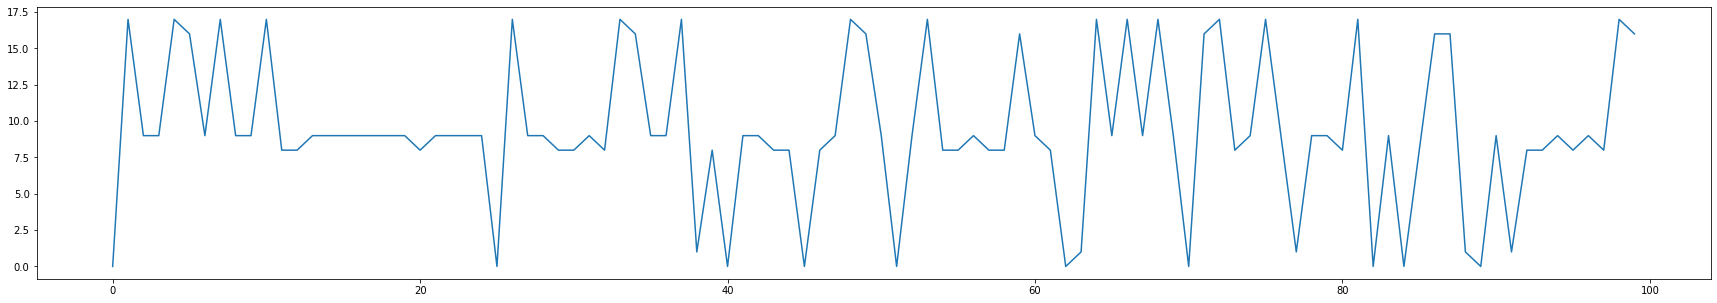

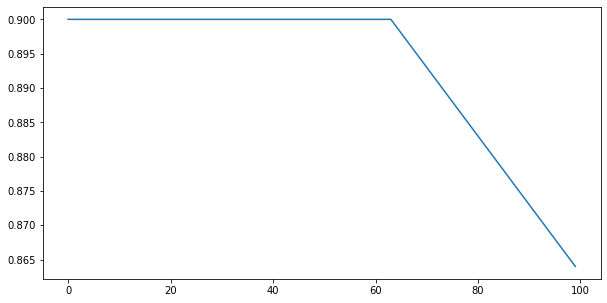

In [ ]:
#simpy testing program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam




random.seed(RANDOM_SEED)

env = simpy.Environment()
num_timeslot = 5
timeslot_duration = 10

num_timeslot = 100
num_timeslot_per_episode = 500
episode = 40


#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=3*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)

#initializing environment

agent = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
  
eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
score = []
average_reward_per_episode = 0


#running the simulation



env.process(rl_env.slot(env,num_timeslot,timeslot_duration,counter,gen,agent,common,i,score,state))


env.run()
plt.figure(figsize=(30,5))
plt.plot(score)
plt.figure(figsize=(10,5))
plt.plot(eps_history)

#problem!!! with this characteristic, the training and interaction with DQN need to implemented within the slot.

Simulation starts, number of timeslot = 2000, timeslot duration = 100, M = 8 K = 5
 0.0000 timelsot No. 00, task 5: allocation failed
20  is reward for timeslot: 0
12  is reward for timeslot: 1
8  is reward for timeslot: 2
300.0000 timelsot No. 03, task 4: allocation failed
300.0000 timelsot No. 03, task 5: allocation failed
12  is reward for timeslot: 3
400.0000 timelsot No. 04, task 5: allocation failed
19  is reward for timeslot: 4
500.0000 timelsot No. 05, task 4: allocation failed
500.0000 timelsot No. 05, task 6: allocation failed
500.0000 timelsot No. 05, task 7: allocation failed
12  is reward for timeslot: 5
12  is reward for timeslot: 6
700.0000 timelsot No. 07, task 4: allocation failed
700.0000 timelsot No. 07, task 6: allocation failed
18  is reward for timeslot: 7
800.0000 timelsot No. 08, task 5: allocation failed
800.0000 timelsot No. 08, task 6: allocation failed
800.0000 timelsot No. 08, task 7: allocation failed
14  is reward for timeslot: 8
900.0000 timelsot No. 09,

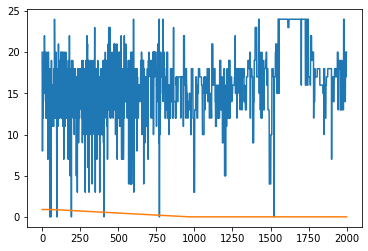

In [ ]:
# Setup and start the simulation

#main program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
  
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam


num_timeslot = 2000
episode = 50

if __name__ == '__main__':
  
  print('Simulation starts, number of timeslot = %d, timeslot duration = %d, M = %d K = %d'%(num_timeslot,timeslot_duration,M,K))
  random.seed(RANDOM_SEED)
  env = simpy.Environment()
  #establishing common resources C_k
  common = []
  for i in range(0,len(C_k)):
    tmp = simpy.Container(env, C_k[i], init=C_k[i])
    common.append(tmp)


  # Start processes and run
  counter = simpy.Resource(env, capacity=2*M) #for processing M different tasks
  state,gen = state_gen(Beta,M,r,common)
  agent = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
  
  eps_history = []
  rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
  score = []
  average_reward_per_episode = 0
  for i in range(num_timeslot):
    #choose random action from replay buffer,or random initialization
    rl_env.interact_with_agent(env,agent,score,state)

    """
    Following code should be replaced with the above method
    """
    action = agent.choose_action(state,M) #returns the action that can be interpreted in simpy!! carefull
  
    true_action = convert_RL_sim_action(action,M)

    #reward = 
    tmp = env.process(rl_env.slot(env,num_timeslot,timeslot_duration,counter,gen,true_action,common,i))

    
    eps_history.append(agent.epsilon)
    env.run()
    #rwd = tmp.value

    #reward = rwd
    reward = rl_env.rewards_per_slot
    
    print(reward," is reward for timeslot:",i)
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,action,reward,new_state)
    state = new_state
    agent.learn()
    #do learning and repaly buffer ops etc...

plt.plot(score)
plt.plot(eps_history)

In [ ]:
# Setup and start the simulation

#main program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
  
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam

print('Simulation starts, number of timeslot = %d, timeslot duration = %d, M = %d K = %d'%(num_timeslot,timeslot_duration,M,K))
random.seed(RANDOM_SEED)
env = simpy.Environment()
#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=2*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)
agent = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
  
eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
score = []
average_reward_per_episode = 0

num_timeslot = 5000
num_timeslot_per_episode = 500
episode = 40
reward_sum = 0
reward_sum_per_episode=[]
sum_reward = 0

Simulation starts, number of timeslot = 10000, timeslot duration = 100, M = 8 K = 5


reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 
reward for 


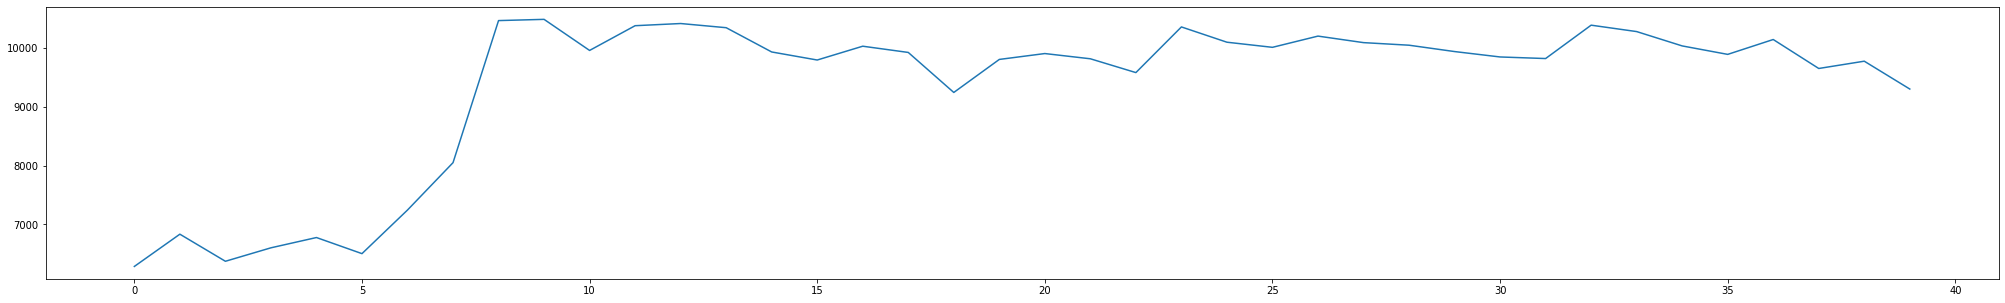

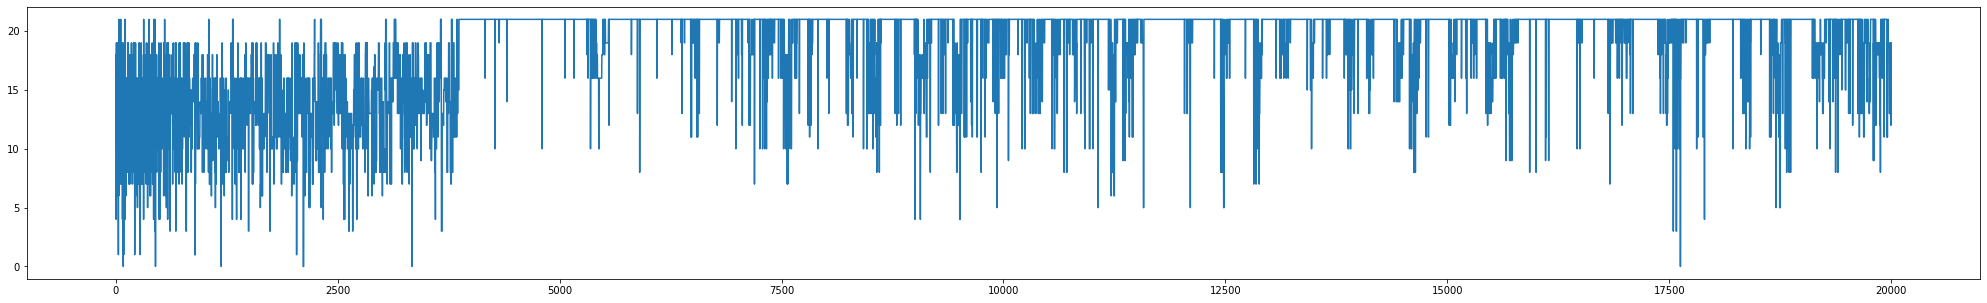

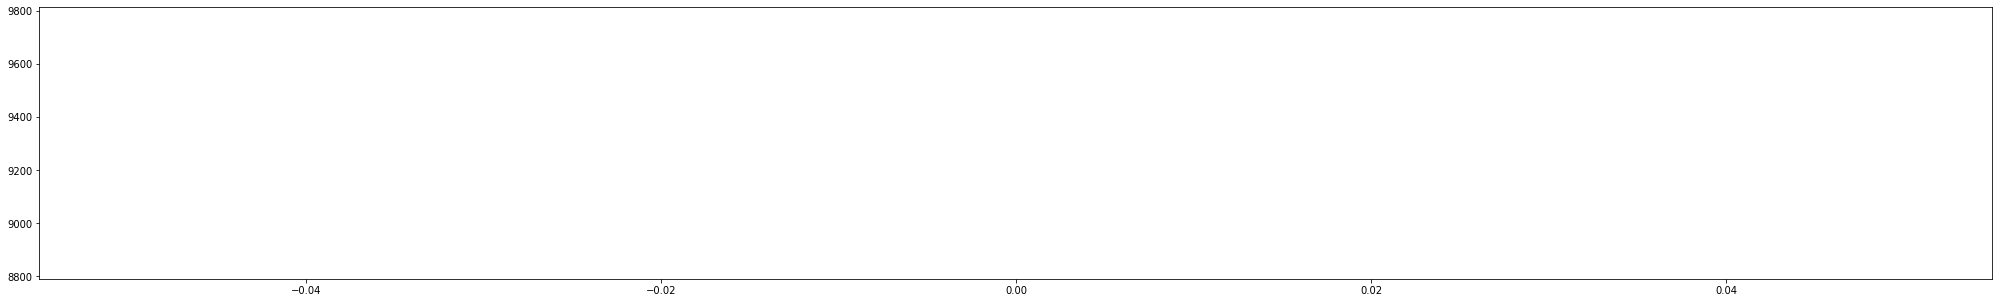

In [ ]:
for j in range(episode):

  reward_sum = 0

  for i in range(num_timeslot_per_episode):
    #choose random action from replay buffer,or random initialization
  
    action = agent.choose_action(state,M) #returns the action that can be interpreted in simpy!! carefull
  
    true_action = convert_RL_sim_action(action,M)

    #reward = 
    tmp = env.process(rl_env.slot(env,num_timeslot,timeslot_duration,counter,gen,true_action,common,i))

    
    eps_history.append(agent.epsilon)
    env.run()
    #rwd = tmp.value

    #reward = rwd
    reward = rl_env.rewards_per_slot
    reward_sum += reward
    sum_reward += reward
    #print(reward," is reward for timeslot:",i)
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,action,reward,new_state)
    state = new_state
    agent.learn()
    #do learning and repaly buffer ops etc...
  print("reward for ")
  reward_sum_per_episode.append(reward_sum)

plt.figure(figsize=(35,5))
plt.plot(reward_sum_per_episode)
plt.figure(figsize=(35,5))
plt.plot(score)
plt.figure(figsize=(35,5))
plt.plot(reward_sum)

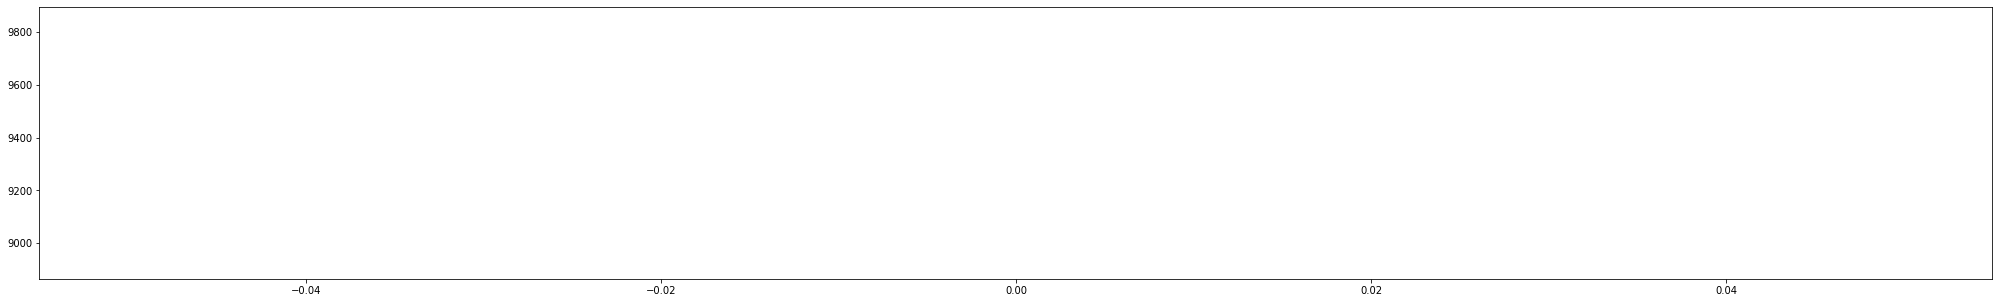

In [ ]:
plt.figure(figsize=(35,5))
plt.plot(reward_sum)

Cases when it starts to work:

[[1 2 1]

 [1 1 1]

 [2 1 2]

 [2 2 2]
 
 [2 1 1]]  
resource required per task per type

[4 1 9 9 6]  
reward per task

[0.1 0.1 0.1 0.1 0.1]  
geometric processing time parameter

[14 14 10]  global resources of type K

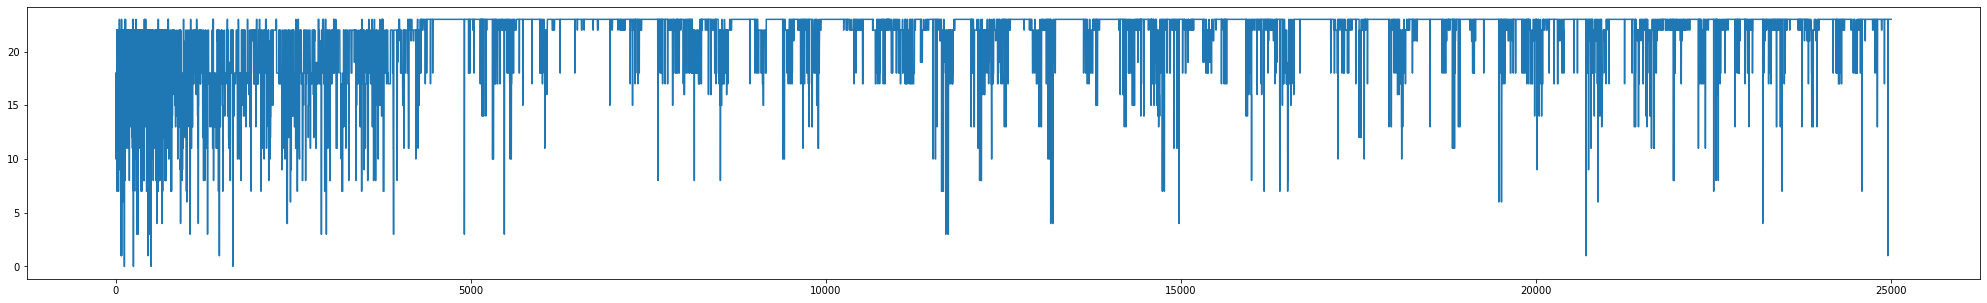

In [ ]:
plt.figure(figsize=(35,5))
plt.plot(score)

In [ ]:
def iterate_sequence(val):
    num = 0
    while num <= val:
        yield num
        num += 1


for i in range(num_timeslot):


    """
    Following code have the problem of not considerting overtime
    env.run() execute all events until finished
    """
    action = np.ones(M) 
  
    env.process(slot(env,num_timeslot,timeslot_duration,counter,gen,action,common,i))   
    env.run()
   
    print("One timeslot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    state = new_state